# 7. Experimentaion with a Smaller Net ( Number of Filters = 64 for each convolution)

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import itertools
from scipy.ndimage.interpolation import shift
import copy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

# Import Dataloader Class and other utilities

In [2]:
from dataloader_2d import *
from dataloader_3d import *

# Build Data loader objects

In [3]:
train_path = '/beegfs/ark576/new_knee_data/train'
val_path = '/beegfs/ark576/new_knee_data/val'
test_path = '/beegfs/ark576/new_knee_data/test'

train_file_names = sorted(pickle.load(open(train_path + '/train_file_names.p','rb')))
val_file_names = sorted(pickle.load(open(val_path + '/val_file_names.p','rb')))
test_file_names = sorted(pickle.load(open(test_path + '/test_file_names.p','rb')))

transformed_dataset = {'train': KneeMRIDataset(train_path,train_file_names, train_data= True, flipping=False, normalize= True),
                       'validate': KneeMRIDataset(val_path,val_file_names, normalize= True),
                       'test': KneeMRIDataset(test_path,test_file_names, normalize= True)
                                          }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=5,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [4]:
im, seg_F, seg_P, seg_T,_ = next(iter(dataloader['train']))

# Find Max and min values of Images (all 7 contrasts), of Fractional Anisotropy maps and of Mean Diffusivity maps for image normalization

In [5]:
min_fa = np.inf
min_md = np.inf
min_image = np.inf
max_fa = 0
max_md = 0
max_image = 0
for data in dataloader['train']:
    if min_fa > torch.min(data[0][:,7,:,:]):
        min_fa = torch.min(data[0][:,7,:,:])
    if min_md > torch.min(data[0][:,8,:,:]):
        min_md = torch.min(data[0][:,8:,:])
    if min_image > torch.min(data[0][:,:7,:,:]):
        min_image = torch.min(data[0][:,:7,:,:])
    if max_fa < torch.max(data[0][:,7,:,:]):
        max_fa = torch.max(data[0][:,7,:,:])
    if max_md < torch.max(data[0][:,8,:,:]):
        max_md = torch.max(data[0][:,8,:,:])
    if max_image < torch.max(data[0][:,:7,:,:]):
        max_image = torch.max(data[0][:,:7,:,:])
norm_values = (max_image, min_image, max_fa, min_fa, max_md, min_md)

# Import Models

In [6]:
from unet_3d import *
from unet_basic_dilated import *
from vnet import *
from ensemble_model import *

In [7]:
seg_sum = torch.zeros(3)
for i, data in enumerate(dataloader['train']):
    input, segF, segP, segT,_ = data
    seg_sum[0] += torch.sum(segF)
    seg_sum[1] += torch.sum(segP)
    seg_sum[2] += torch.sum(segT)
mean_s_sum = seg_sum/i

## Import Loss functions and all other utility functions like functions for saving models, for visualizing images, etc.

In [8]:
from utils import *

## Import all the Training and evaluate functions to evaluate the models

In [10]:
from train_2d import *
from train_3d import *
from train_ensemble import *
from evaluate_2d import *
from evaluate_3d import *
from evaluate_ensemble import *

# 7. Experimentaion with a Smaller Net ( Number of Filters = 64 for each convolution)

In [169]:
model_gen_dilated_small = Unet_dilated_small(9,4,dropout = True).cuda()

In [163]:
count_parameters(model_gen_dilated_small)

1310660

## Original Net had 48 million parameters whereas smaller net have 1.31 million.

In [178]:
optimizer_dilated_small = optim.Adam(model_gen_dilated_small.parameters(),lr = 1e-5)

In [179]:
model_gen_dilated_small, loss_hist_small, dc_hist_0_small, \
dc_hist_1_small, dc_hist_2_small = train_model(model_gen_dilated_small, optimizer_dilated_small,
                                                     dataloader,data_sizes,5,'new_data_dilated_small_2',
                                                     num_epochs=20, verbose = True, 
                                                     dice_loss = dice_loss_3)

Epoch: 0, Phase: train, epoch loss: 0.3639, Dice Score (class 0): 0.6885, Dice Score (class 1): 0.8123,Dice Score (class 2): 0.7587
----------
Epoch: 0, Phase: validate, epoch loss: 0.4494, Dice Score (class 0): 0.6662, Dice Score (class 1): 0.7487,Dice Score (class 2): 0.5864
----------
Epoch: 1, Phase: train, epoch loss: 0.3596, Dice Score (class 0): 0.6869, Dice Score (class 1): 0.8101,Dice Score (class 2): 0.7647
----------
Epoch: 1, Phase: validate, epoch loss: 0.4465, Dice Score (class 0): 0.6800, Dice Score (class 1): 0.7478,Dice Score (class 2): 0.5929
----------
Epoch: 2, Phase: train, epoch loss: 0.3542, Dice Score (class 0): 0.6900, Dice Score (class 1): 0.8130,Dice Score (class 2): 0.7632
----------
Epoch: 2, Phase: validate, epoch loss: 0.4543, Dice Score (class 0): 0.6613, Dice Score (class 1): 0.7340,Dice Score (class 2): 0.6019
----------
Epoch: 3, Phase: train, epoch loss: 0.3540, Dice Score (class 0): 0.6925, Dice Score (class 1): 0.8124,Dice Score (class 2): 0.7662
-

In [180]:
# torch.save(model_gen_dilated_l4_n2_new_data_dp,'new_data_dilated_net_l4_n2_nd_dp_1')
pickle.dump(loss_hist_small, open('loss_hist_new_data_dilated_small_2','wb'))
pickle.dump(dc_hist_0_small, open('dc_hist_0_new_data_dilated_small_2','wb'))
pickle.dump(dc_hist_1_small, open('dc_hist_1_new_data_dilated_small_2','wb'))
pickle.dump(dc_hist_2_small, open('dc_hist_2_new_data_dilated_small_2','wb'))

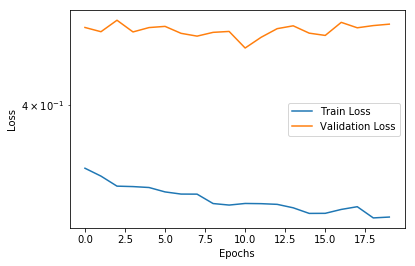

In [181]:
plot_hist(loss_hist_small,'Loss')

True Map


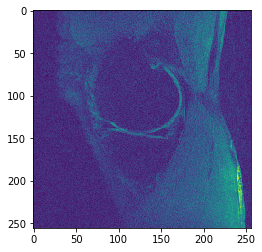

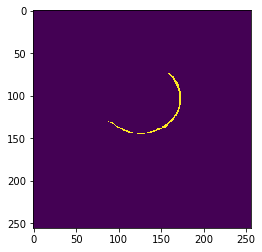

Predicted Map


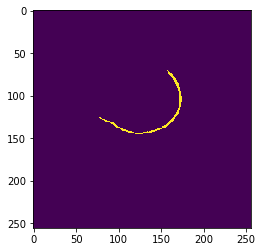

True Map


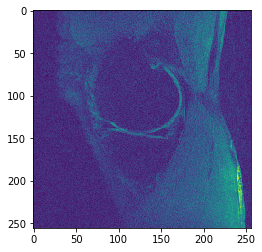

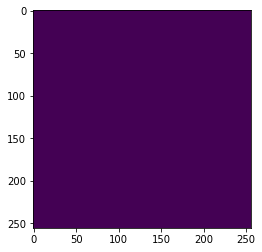

Predicted Map


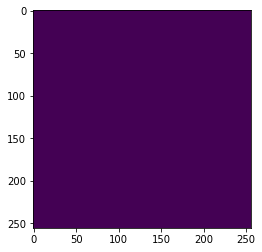

True Map


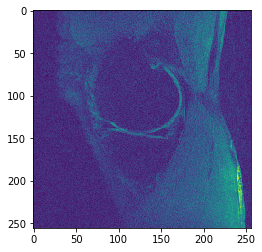

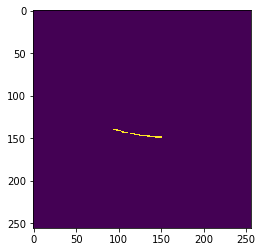

Predicted Map


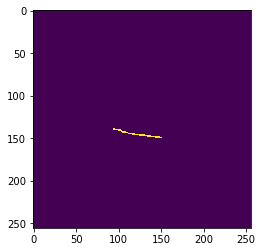

True Map


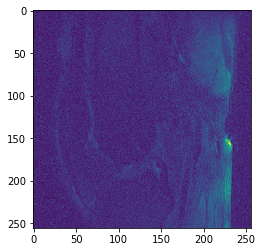

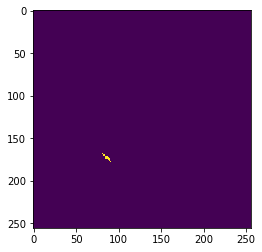

Predicted Map


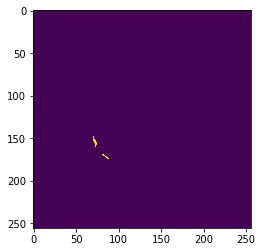

True Map


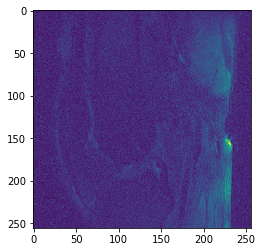

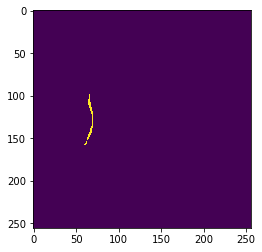

Predicted Map


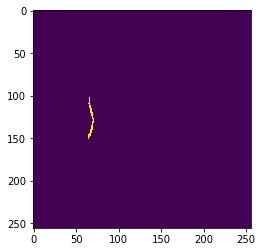

True Map


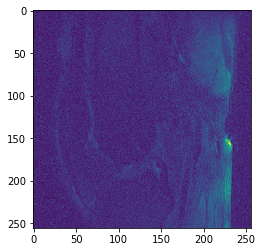

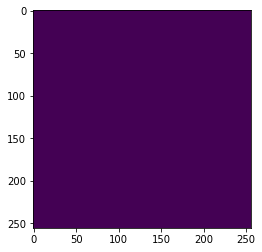

Predicted Map


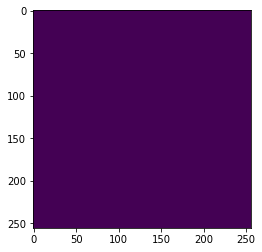

True Map


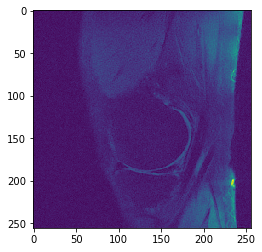

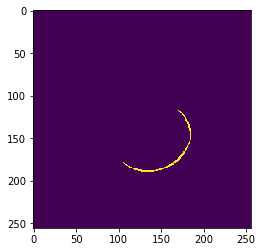

Predicted Map


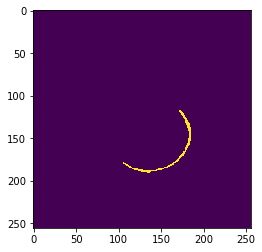

True Map


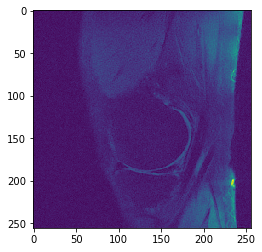

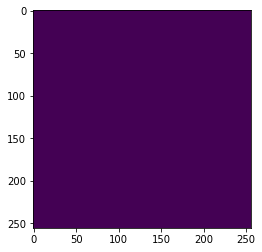

Predicted Map


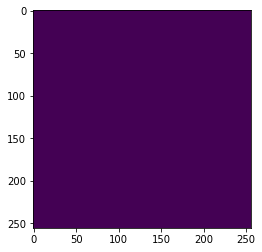

True Map


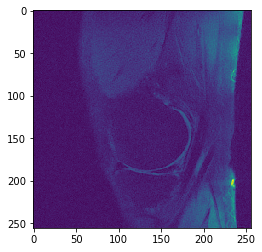

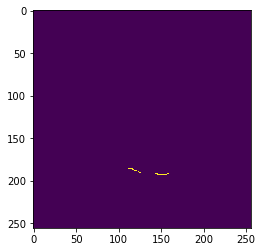

Predicted Map


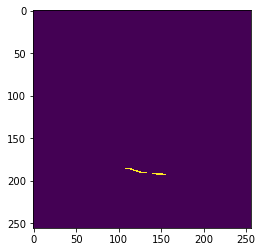

True Map


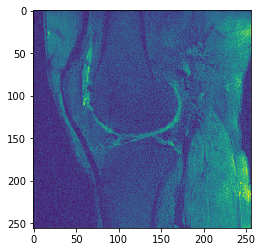

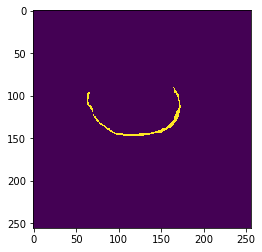

Predicted Map


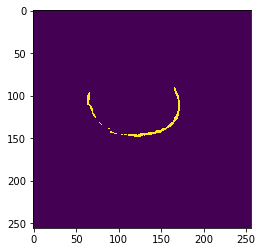

True Map


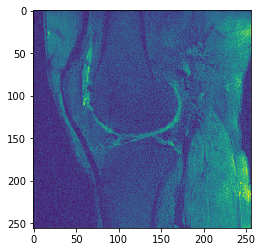

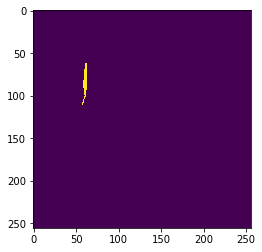

Predicted Map


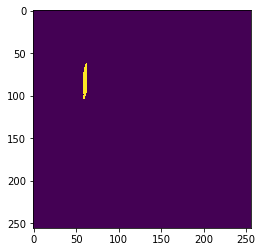

True Map


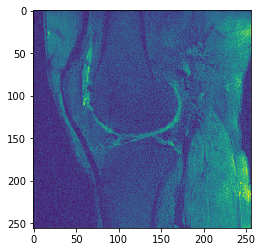

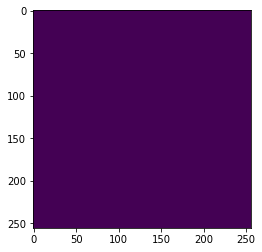

Predicted Map


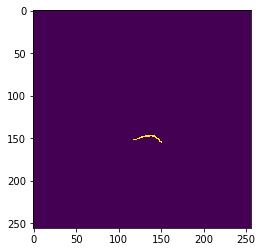

True Map


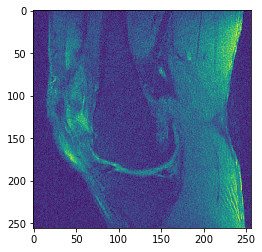

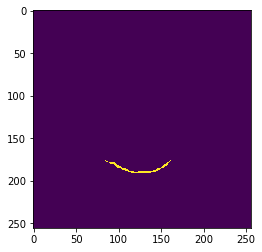

Predicted Map


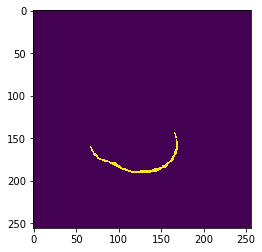

True Map


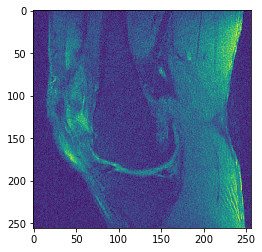

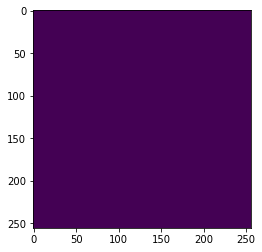

Predicted Map


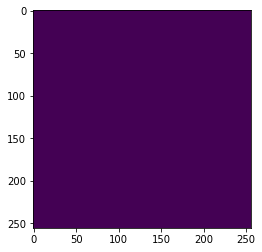

True Map


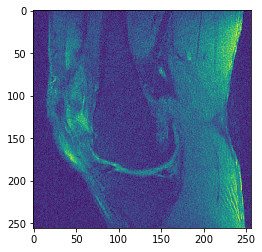

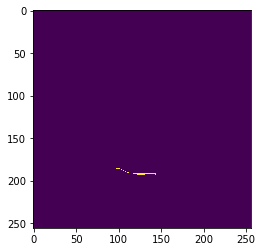

Predicted Map


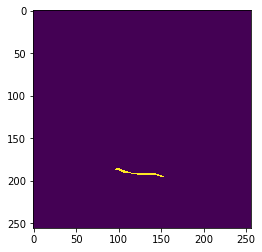

True Map


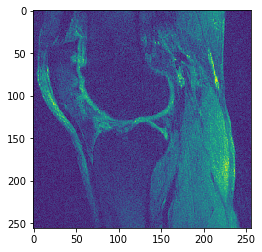

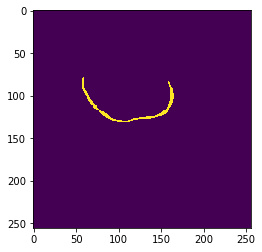

Predicted Map


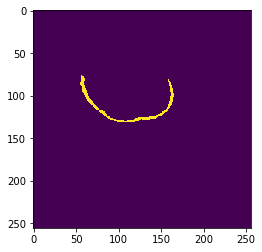

True Map


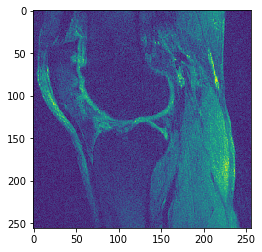

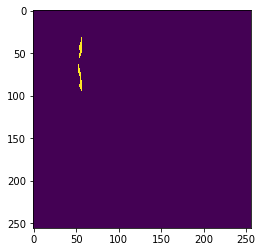

Predicted Map


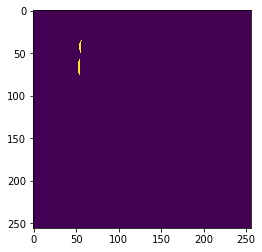

True Map


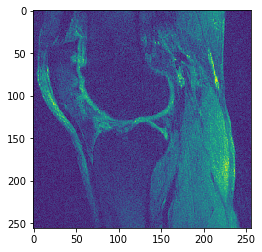

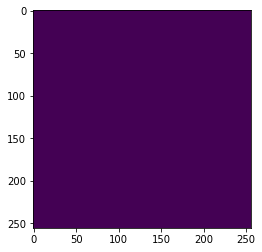

Predicted Map


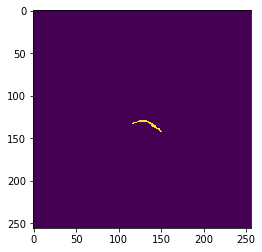

True Map


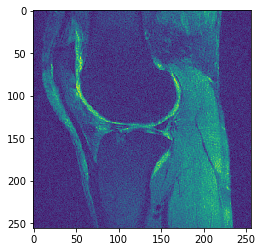

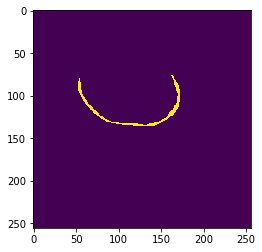

Predicted Map


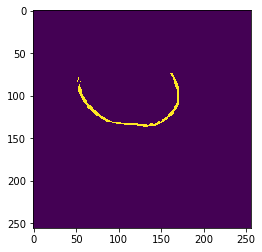

True Map


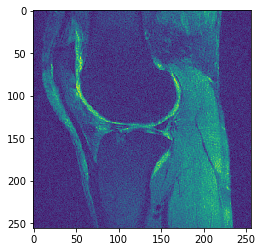

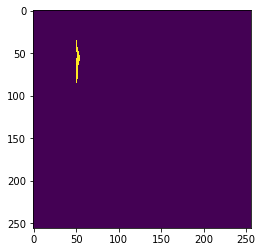

Predicted Map


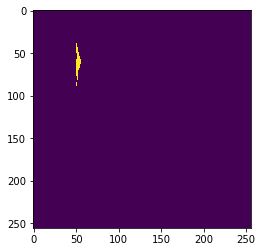

True Map


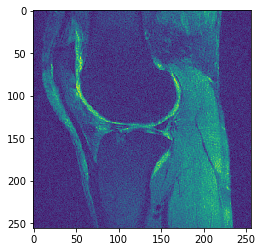

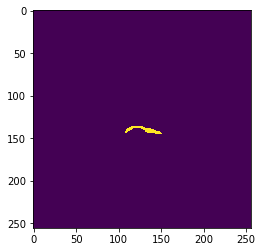

Predicted Map


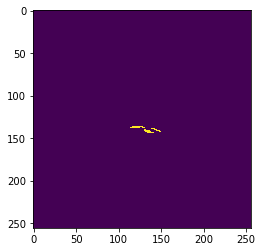

True Map


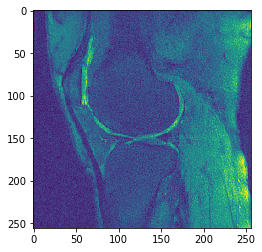

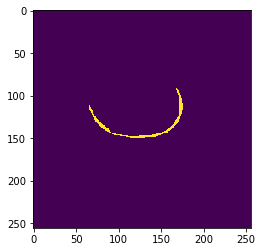

Predicted Map


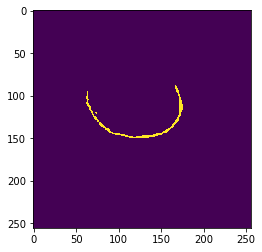

True Map


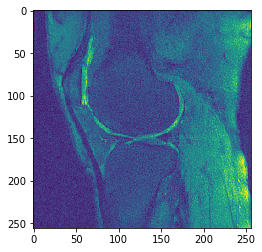

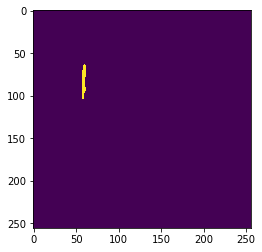

Predicted Map


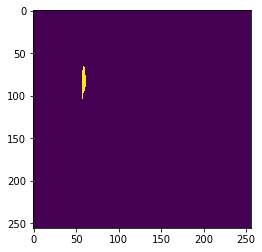

True Map


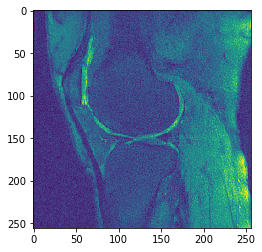

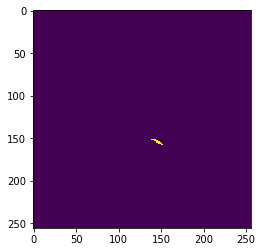

Predicted Map


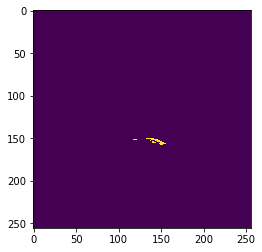

True Map


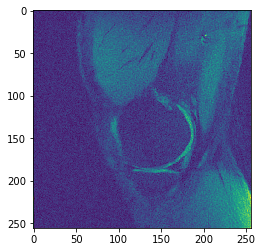

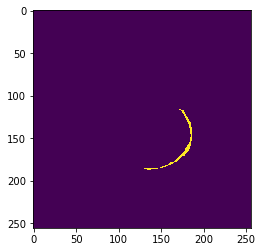

Predicted Map


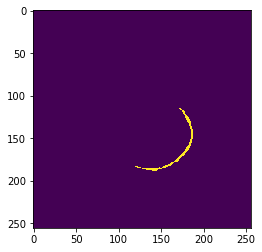

True Map


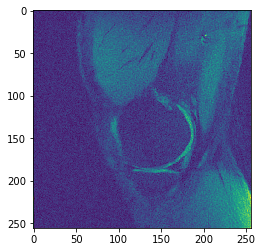

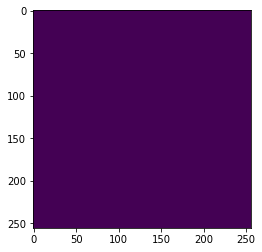

Predicted Map


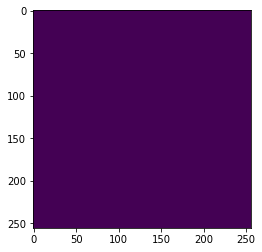

True Map


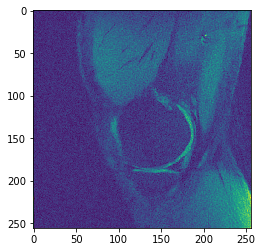

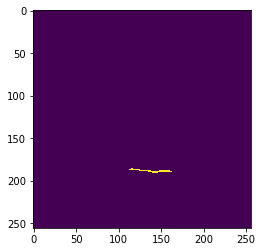

Predicted Map


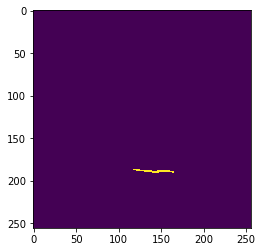

True Map


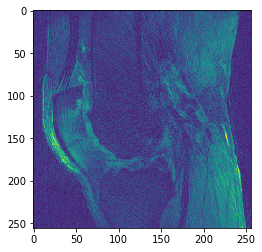

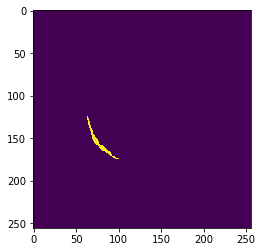

Predicted Map


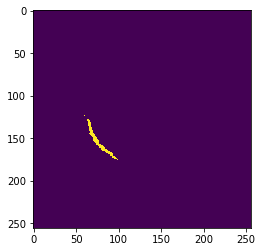

True Map


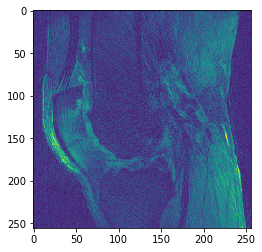

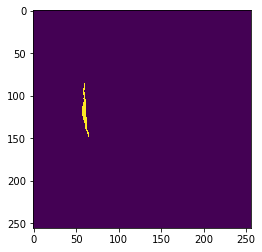

Predicted Map


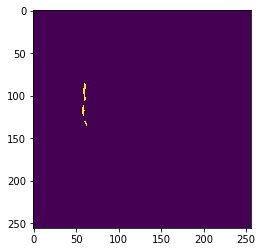

True Map


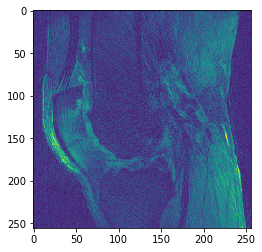

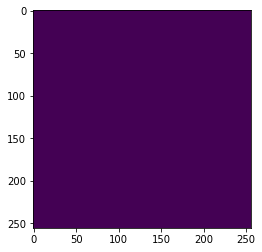

Predicted Map


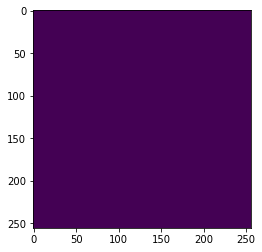

validate loss: 0.4526, Dice Score (class 0): 0.6699, Dice Score (class 1): 0.7493,Dice Score (class 2): 0.5902


(0.45261806391534354,
 0.669879348505111,
 0.7492644190788269,
 0.5902376955463773)

In [175]:
evaluate(model_gen_dilated_small, dataloader, data_sizes, 5, 'validate', dice_loss=dice_loss_3)

In [270]:
loaded_model = torch.load('new_data_dilated_small_1')

True Map


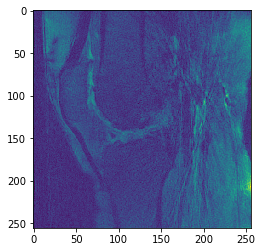

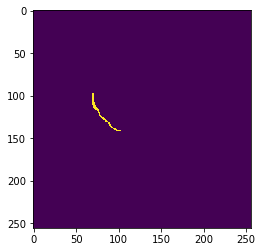

Predicted Map


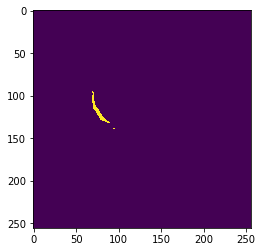

True Map


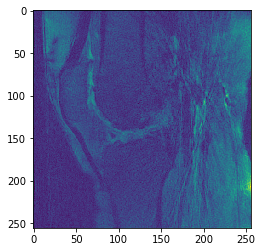

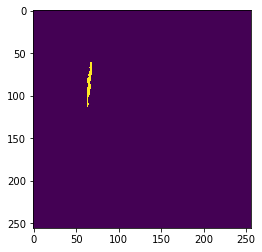

Predicted Map


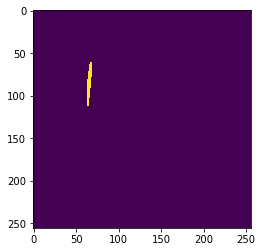

True Map


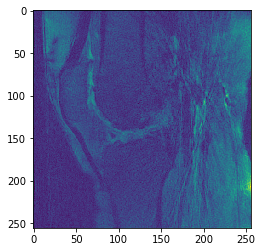

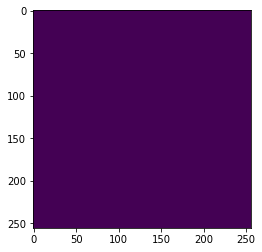

Predicted Map


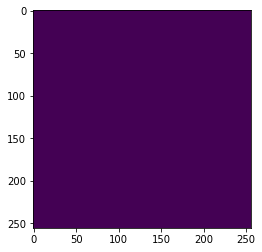

True Map


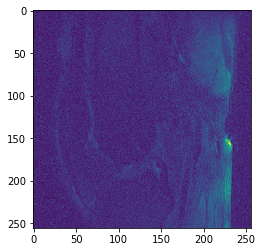

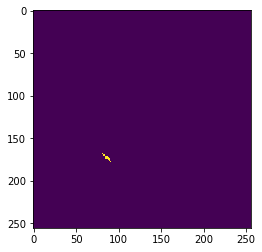

Predicted Map


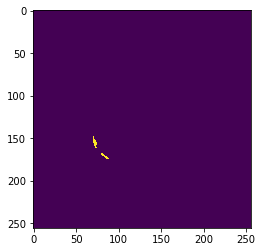

True Map


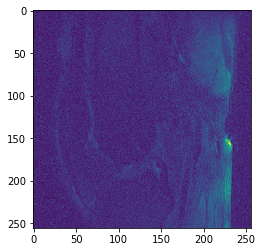

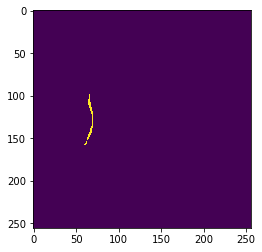

Predicted Map


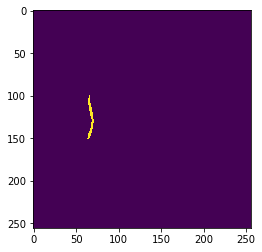

True Map


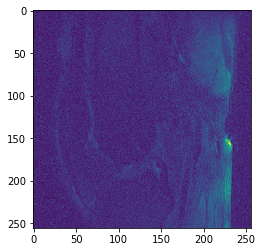

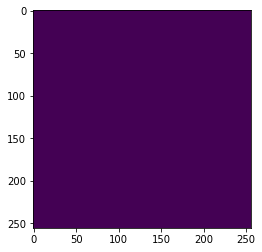

Predicted Map


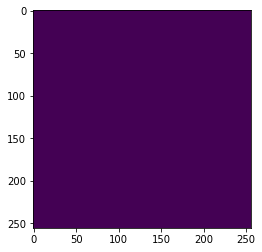

True Map


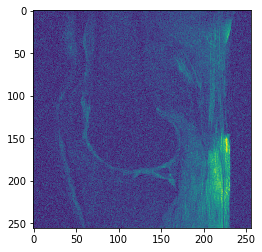

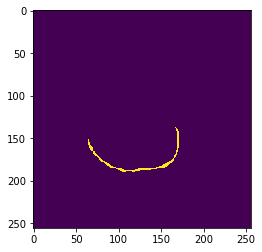

Predicted Map


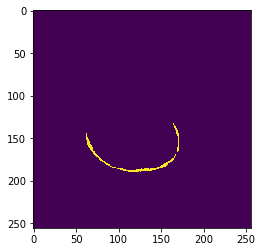

True Map


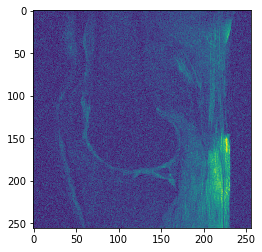

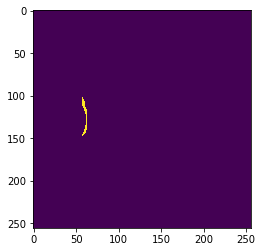

Predicted Map


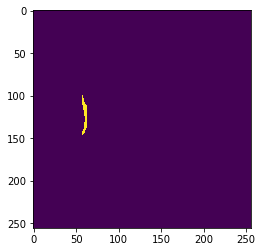

True Map


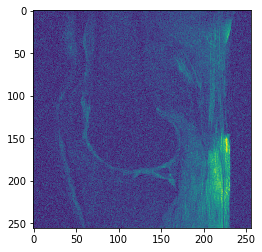

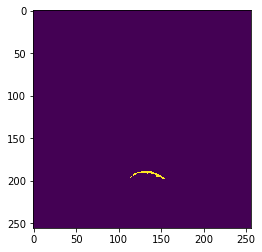

Predicted Map


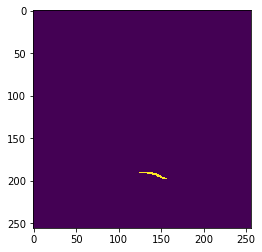

True Map


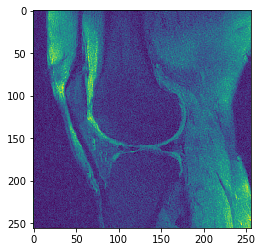

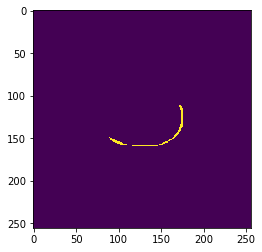

Predicted Map


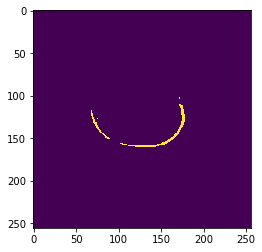

True Map


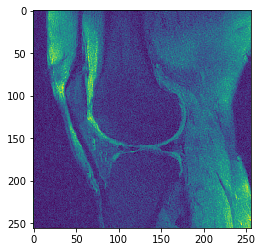

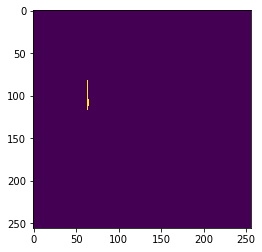

Predicted Map


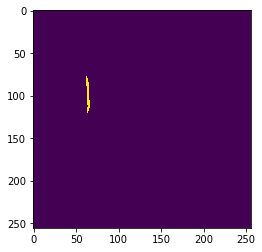

True Map


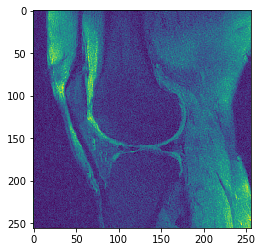

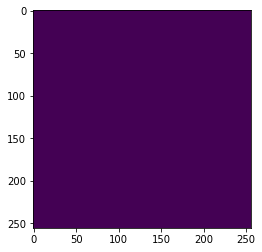

Predicted Map


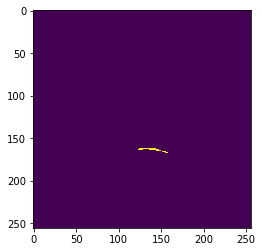

True Map


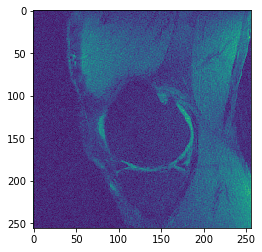

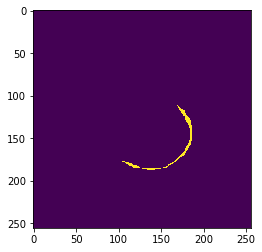

Predicted Map


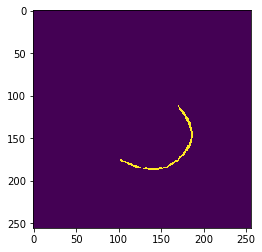

True Map


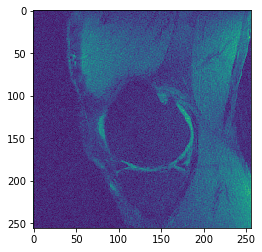

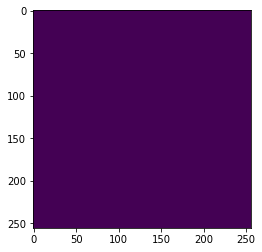

Predicted Map


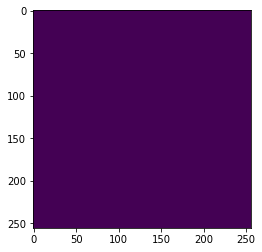

True Map


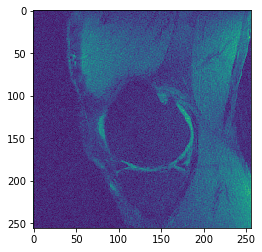

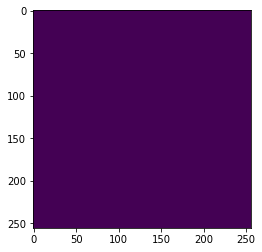

Predicted Map


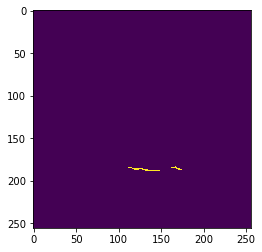

True Map


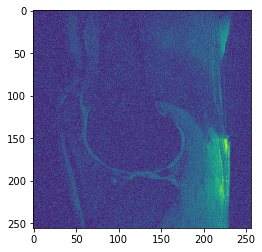

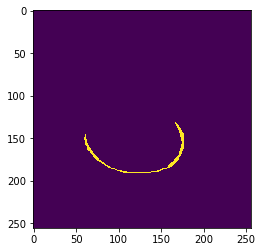

Predicted Map


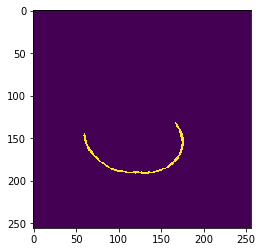

True Map


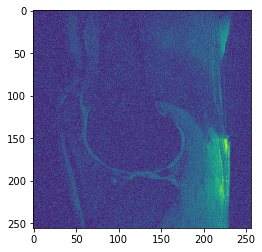

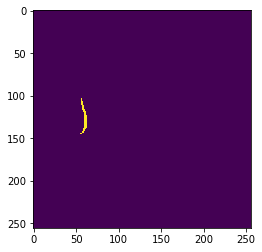

Predicted Map


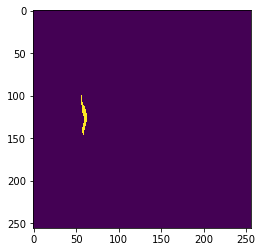

True Map


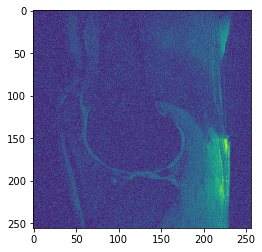

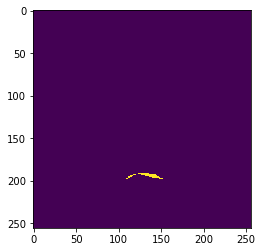

Predicted Map


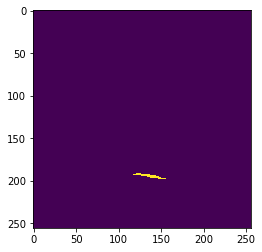

True Map


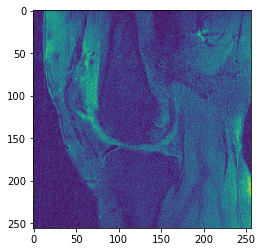

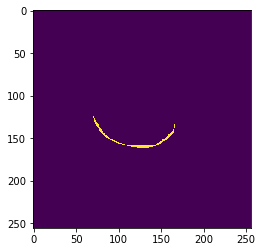

Predicted Map


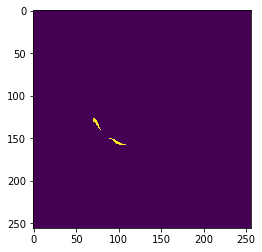

True Map


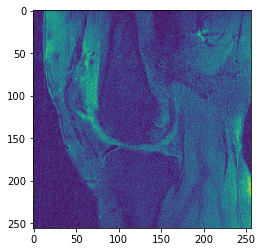

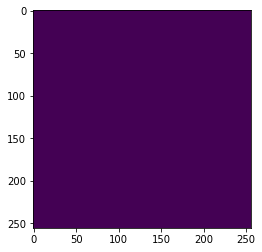

Predicted Map


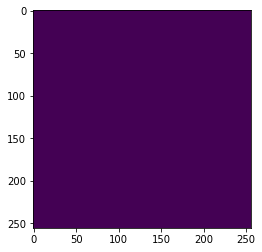

True Map


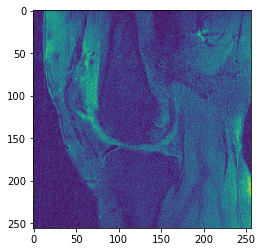

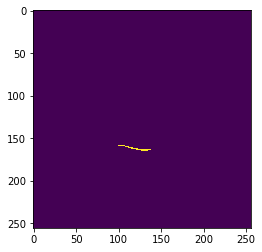

Predicted Map


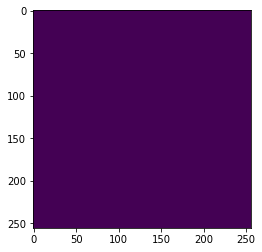

True Map


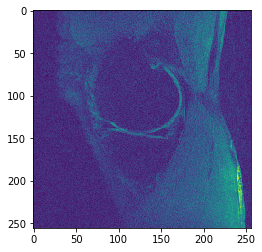

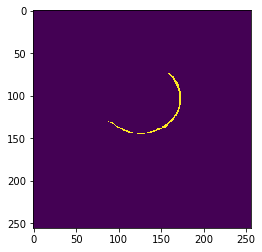

Predicted Map


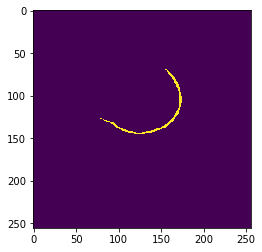

True Map


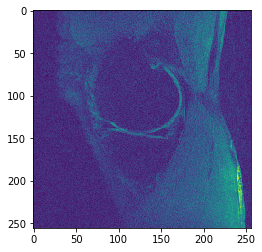

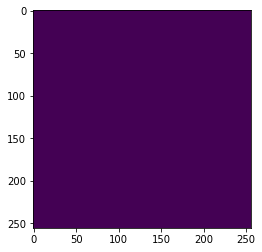

Predicted Map


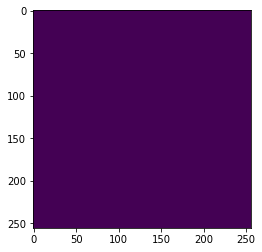

True Map


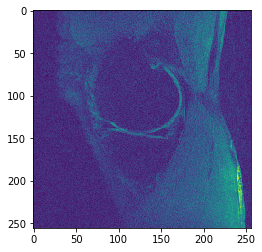

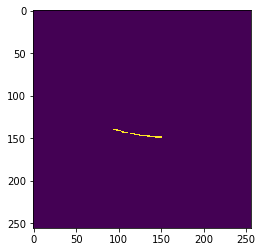

Predicted Map


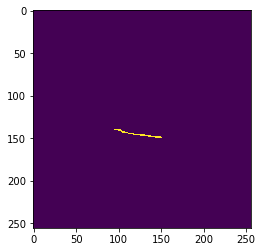

True Map


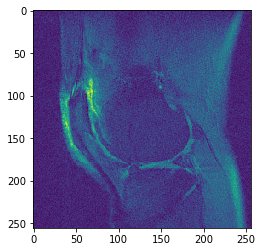

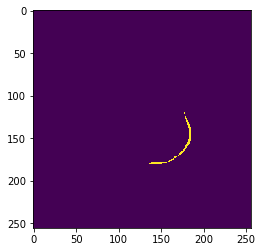

Predicted Map


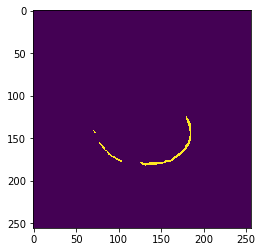

True Map


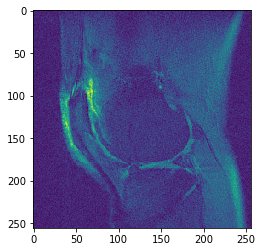

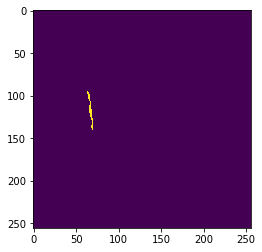

Predicted Map


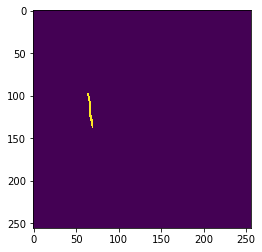

True Map


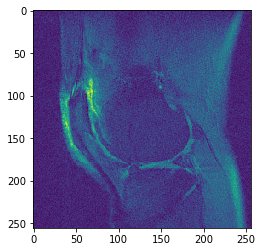

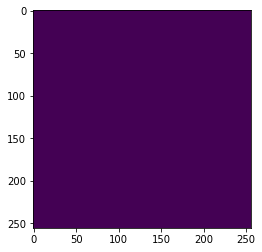

Predicted Map


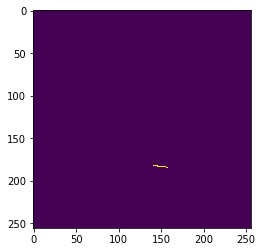

True Map


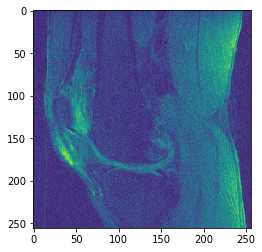

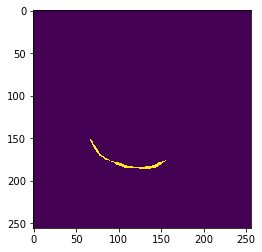

Predicted Map


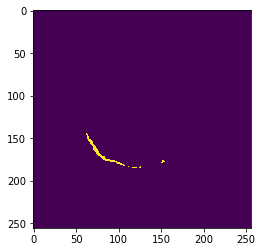

True Map


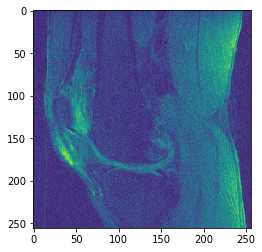

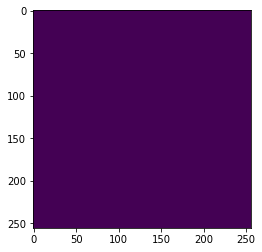

Predicted Map


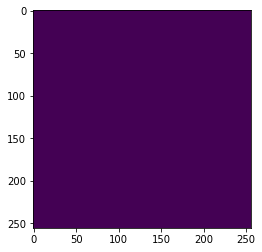

True Map


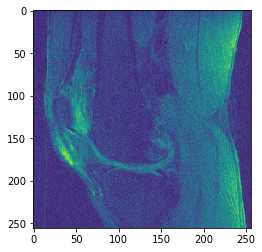

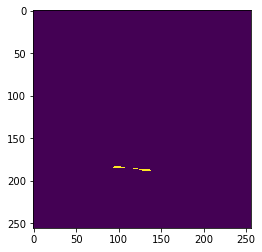

Predicted Map


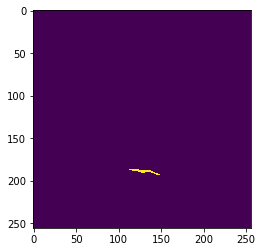

validate loss: 0.4315, Dice Score (class 0): 0.6723, Dice Score (class 1): 0.7727,Dice Score (class 2): 0.6131


(0.4315390686194102, 0.672312156075523, 0.7726615156446185, 0.6131050061611902)

In [265]:
evaluate(loaded_model, dataloader, data_sizes, 5, 'validate', dice_loss=dice_loss_3)

# Discussion
As it can be seen, the performance is still the same as the bigger net. Hence, it proves our hypothesis that many of parameters were not required.